# DATA CLEANING FOR MO DATA -- USING VA TEMPORARILY

In [1]:
# import pandas as pd

In [2]:
# # Data at https://doc.mo.gov/media-center/sunshine-law
# raw_data = open("../../state/MO/MO_data/MO_raw", "r", encoding='utf-8')

In [3]:
# print(dir(raw_data))

In [4]:
# # df = pd.read_fwf("../../state/MO/MO_data/MO_raw", encoding='utf-8')
# df = pd.DataFrame()

# # Index names: https://doc.mo.gov/sites/doc/files/2018-01/sunshine_layout.xml
# # Index descriptions: https://doc.mo.gov/sites/doc/files/2018-01/sunshine_desc.xml
# # Missouri Charge is in-depth crime description code
# # CC/CS has flag whether sentences are concurrent, consecutive
# # Sentence means incarceration, probation sentence means probation
# df.index = ['DOC ID', 'Last Name', 'First Name', 'Middle Name', 'Generation/Suffix',
#             'Race', 'Sex', 'Birth Date', 'Offender Assigned Place', 'DOC Loc Func Flag',
#             'Cause Number', 'Offense County', 'Sentence County', 'NCIC Code',
#             'Missouri Charge', 'Offense Description', 'Completed Flag', 'CC/CS Ind',
#             'Sentencing Date', 'Max Release Date', 'Min Release Date',
#             'Sentence Length Years', 'Sentence Length Months', 'Sentence Length Days',
#             'Probation Sentence Date', 'Probation Type', 'Probation Term Years',
#             'Probation Term Months', 'Probation Term Days']

# count = 0
# for line in raw_data:
# #     try:
#     print(line)
# #         split_line = line.split("  ")
#     #     print(split_line)
# #         split_line_cleaned = []
# #         for section in split_line:
# #             if section != '':
# #                 split_line_cleaned.append(section)
#     #     print(line)
#     #     print(split_line_cleaned)
#     #     print(len(split_line_cleaned))

# #         new_row = [line[0:8], line[8:16]]
#     #     print(new_row)
#     #     df = pd.concat([df, split_line])

# #     except:
        
#     count += 1
    
#     if (count >= 10):
#         break
        
    
# print(count)
# # df.to_csv("../../state/MO/MO_data/MO_raw", encoding='utf-8')

In [5]:
# We're importing a bunch of libraries here that we'll be using below.

import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
from functools import partial

pd.set_option('display.max_rows', 500)

# Data cleaning (WITH VA DATA)

In [6]:
raw_va_sentence_df = pd.read_csv(
    '../../state/VA/VA_data/unprocessed_va_historical_sentences_v2.csv',
    sep='\t'
)
raw_va_sentence_df['crime_type'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['offense_code'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['crime'] = raw_va_sentence_df['Off1VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['fiscal_year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df = raw_va_sentence_df.rename({'Off1Date':'offense_date'}, axis=1)
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.sentence_type_code != 1]
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.effective_sentence_months != 0]

raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['crime_type'].str.contains('Total')]
raw_va_sentence_df = raw_va_sentence_df.drop(
    ['VCC', 'Offense Group', 'Off1VCC', 'JudgeID', 'ActDisp', 'effsent', 'FiscalYr', 'EffLif'],
    axis=1
)
raw_va_sentence_df.head()

,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,3.0,18.0,2018.0,0.0
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,3.0,10.0,2019.0,0.0
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2017.0,0.0
5,11/17/2018,SPRADLEY,CALEB,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2019.0,0.0
7,12/11/2016,JAMES,ERIC,ASSAULT,ASL1316,ASL1316F6,10KW,3.0,14.0,2017.0,0.0


In [7]:
relevant_data = raw_va_sentence_df[['offense_date', 'judge_id', 'effective_sentence_months']]
relevant_data = relevant_data.rename({'judge_id': 'Age'}, axis=1)
relevant_data['Age'] = relevant_data['Age'].apply(lambda x: np.random.randint(20,85))

In [8]:
relevant_data.head()

,offense_date,Age,effective_sentence_months
0,5/20/2017,39,18.0
1,4/25/2018,52,10.0
4,12/25/2016,84,7.0
5,11/17/2018,66,7.0
7,12/11/2016,61,14.0


# Preprocessing

In [9]:
# Calculate LOS using our percentage served data
# sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

sorted_data = relevant_data
sorted_data = sorted_data[~sorted_data['offense_date'].isna()]
sorted_data = sorted_data.rename({'effective_sentence_months': 'LOS'}, axis=1)

# Create age groups for the policy:
# - YOUNG = <55
# - MID = 55-60
# - OLD = 60-65
# - ELDERLY = >65

def get_age_group(age):
    if age < 55:
        return 'YOUNG'
    elif age >= 55 and age < 60:
        return 'MID'
    elif age >= 60 and age < 65:
        return 'OLD'
    else:
        return 'ELDERLY'

sorted_data['age_group'] = sorted_data['Age'].apply(get_age_group) 

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
def extract_year(date_str):
    return int(date_str.split('/')[-1])

def extract_month(date_str):
    return int(date_str.split('/')[0])

sorted_data['year'] = sorted_data['offense_date'].apply(extract_year)
sorted_data['month'] = sorted_data['offense_date'].apply(extract_month)
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
admissions_data = sorted_data.groupby(['time_step', 'age_group']).count()[['offense_date']].reset_index().rename(
    {'offense_date': 'cohort_population'}, axis=1
)
admissions_data['compartment'] = 'pretrial'
admissions_data['admission_to'] = 'prison'
# [CHANGE 33 DEPENDING ON WHEN THE BILL COMES INTO EFFECT!!! WE THINK IT'S 66]
admissions_data = admissions_data[(admissions_data['time_step'] <= 66)] #(admissions_data['time_step'] > -108) & 
admissions_data.time_step = admissions_data.time_step.astype(int)
admissions_data.cohort_population = admissions_data.cohort_population.astype(float)
admissions_data.head()

,time_step,age_group,cohort_population,compartment,admission_to
0,-484,YOUNG,1.0,pretrial,prison
1,-468,ELDERLY,1.0,pretrial,prison
2,-467,YOUNG,1.0,pretrial,prison
3,-447,ELDERLY,1.0,pretrial,prison
4,-443,OLD,1.0,pretrial,prison


In [10]:
age_groups = sorted_data['age_group'].unique()

# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'age_group'
]).count()[['offense_date']].reset_index().rename({'offense_date': 'cohort_portion'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

transitions_data = transitions_data.rename({"total_population": "cohort_portion"})

transitions_data = pd.concat([transitions_data, pd.DataFrame({
    'compartment_duration': [24] * len(age_groups),
    'cohort_portion': [1] * len(age_groups),
    'compartment': ['release'] * len(age_groups),
    'outflow_to': ['release'] * len(age_groups),
    'age_group': age_groups,
})], ignore_index=True)

transitions_data.cohort_portion = transitions_data.cohort_portion.astype(float)
transitions_data.head()

,compartment_duration,age_group,cohort_portion,compartment,outflow_to
0,1.0,ELDERLY,1000.0,prison,release
1,1.0,MID,253.0,prison,release
2,1.0,OLD,261.0,prison,release
3,1.0,YOUNG,1893.0,prison,release
4,2.0,ELDERLY,669.0,prison,release


In [11]:
#Create alternate transitions table for policy scenario
# FINISH THIS!!!

# This estimates resentencing frequency/outcomes using the parole set-off system used in Texas
# see https://www.secondlooktexas.org/action
GRANT_RATE = 3 / (32 + 3)  # SHOULD BE 3 / (32 + 3) -- JUST TESTING

# If rejected, must wait a year to reapply
# Adding an extra year for processing and re-application time
SETOFF_TIME = 24
alternate_transitions_data = pd.DataFrame()

# Tiers set by crime type -- tier 0 is not included because it means ineligible
# TIERS = transitions_data['age_group'].unique().astype("int64")
# Months of sentence that must be served to be eligible for parole
age_group_sentence_lengths = [float("NaN"), 15 * 12, 10 * 12, 5 * 12]


for age_group_enum in enumerate(age_groups):
    age_group_idx, age_group = age_group_enum
    eligible_data = transitions_data[
        (transitions_data['compartment'] == 'prison')
        & (transitions_data['age_group'] == age_group)
    ].copy()

    if eligible_data.size > 0 and age_group == 'YOUNG':
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'age_group', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = pd.concat([alternate_transitions_data, eligible_data])

    elif eligible_data.size > 0:
        for i in range(age_group_sentence_lengths[age_group_idx], int(eligible_data.compartment_duration.max()), SETOFF_TIME):
            rate = GRANT_RATE
            
            # calculate population that still hasn't been released by now
            remaining_population = eligible_data.loc[
                eligible_data['compartment_duration'] > i, 'cohort_portion'
            ].sum()

            print("Total population before", eligible_data['cohort_portion'].sum())
            
            # reduce the population size of people staying in prison longer than this by the number of people being
            # released via resentencing right now
            eligible_data.loc[eligible_data['compartment_duration'] > i, 'cohort_portion'] *= 1 - rate
            
            # add in rows of data for the people being released right now via resentencing
            eligible_data = pd.concat([eligible_data, pd.DataFrame({
                'compartment_duration': [i],
                'cohort_portion': [rate*remaining_population],
                'age_group': [age_group],
                'compartment': ['prison'],
                'outflow_to': ['release']
            })], ignore_index=True)

            print("Total population after", eligible_data['cohort_portion'].sum())
        
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'age_group', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = pd.concat([alternate_transitions_data, eligible_data])

# Round population numbers to avoid tiny populations in weird places
alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.apply(lambda x: round(x, 5))
# drop the rows that are now rounded to zero
alternate_transitions_data = alternate_transitions_data[alternate_transitions_data.cohort_portion > 0]

alternate_transitions_data = pd.concat([alternate_transitions_data, pd.DataFrame({
    'compartment_duration': [24] * len(age_groups),
    'cohort_portion': [1] * len(age_groups),
    'compartment': ['release'] * len(age_groups),
    'outflow_to': ['release'] * len(age_groups),
    'age_group': list(age_groups),
})], ignore_index=True)

alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.astype(float)
alternate_transitions_data.head()

Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 15103.0
Total population before 15103.0
Total population after 

,compartment,compartment_duration,age_group,outflow_to,cohort_portion
0,prison,1.0,YOUNG,release,1893.0
1,prison,2.0,YOUNG,release,1173.0
2,prison,3.0,YOUNG,release,2488.0
3,prison,4.0,YOUNG,release,851.0
4,prison,5.0,YOUNG,release,356.0


In [13]:
# change names to fit model expectations
admissions_data = admissions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
admissions_data['simulation_group'] = admissions_data['simulation_group'].astype(str)
admissions_data['time_step'] = admissions_data['time_step'].astype('int64')

transitions_data = transitions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
transitions_data['simulation_group'] = transitions_data['simulation_group'].astype(str)

alternate_transitions_data = alternate_transitions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
alternate_transitions_data['simulation_group'] = alternate_transitions_data['simulation_group'].astype(str)

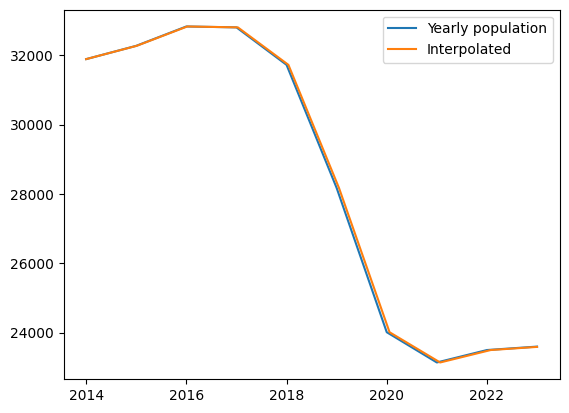

In [14]:
# From https://doc.mo.gov/media/pdf/offender-profile-fy23
total_pop = {
    2014: 31889,
    2015: 32273,
    2016: 32831,
    2017: 32805,
    2018: 31724,
    2019: 28172,
    2020: 24010,
    2021: 23137,
    2022: 23496,
    2023: 23595
}

# Interpolates yearly numbers to estimate monthly
def lerp(pop_start, pop_end):
    months = range(12)
    monthly_pop = []
    
    for month in months:
        # Linear interpolation between pop_start and pop_end
        pop = (pop_start * (12 - month) + pop_end * month) / 12
        monthly_pop.append(pop)
    
    return monthly_pop
    
monthly_populations = []

for year in total_pop:
    if year < 2023:
        monthly_populations += lerp(total_pop[year], total_pop[year + 1])
    
# Plot to check interpolation worked properly
plt.plot(np.arange(2014, 2024), [total_pop[year] for year in total_pop], label="Yearly population")
plt.plot(np.linspace(2014, 2023, len(monthly_populations)), monthly_populations, label="Interpolated")
plt.legend()

In [15]:
population_data = pd.DataFrame({
    'time_step': range(len(monthly_populations)),
    'compartment_population': monthly_populations
})
population_data['compartment'] = 'prison'
population_data['compartment_population'] = population_data['compartment_population'].astype(float)
population_data['time_step'] -= 5 * 12 # Makes time_step relative to reference year (2019, or 5*12 timesteps after 2014)

population_data

,time_step,compartment_population,compartment
0,-60,31889.000000,prison
1,-59,31921.000000,prison
2,-58,31953.000000,prison
3,-57,31985.000000,prison
4,-56,32017.000000,prison
5,-55,32049.000000,prison
6,-54,32081.000000,prison
7,-53,32113.000000,prison
8,-52,32145.000000,prison
9,-51,32177.000000,prison


In [17]:
transitions_data['simulation_group'].unique()

array(['ELDERLY', 'MID', 'OLD', 'YOUNG', '0.0', '1.0', '2.0', '3.0',
       '4.0'], dtype=object)

## Adjustments to make sure the model doesn't break

In [27]:
# Ensure admissions has data for each simulation group
for i in range(population_data['time_step'].min(), population_data['time_step'].max()):
    addtl_admissions = pd.DataFrame({
        'simulation_group': age_groups,
        'time_step': [i] * len(age_groups),
        'compartment': ['pretrial'] * len(age_groups),
        'cohort_population': [1e-5] * len(age_groups),
        'admission_to': ['prison'] * len(age_groups)
    })
    admissions_data = pd.concat([admissions_data, addtl_admissions], ignore_index=True)

In [24]:
# Ensure transitions has data for each simulation group
addtl_transitions = pd.DataFrame({
    'simulation_group': age_groups,
    'compartment': ['prison']*len(age_groups),
    'compartment_duration': [24]*len(age_groups),
    'cohort_portion': [1e-5]*len(age_groups),
    'outflow_to': ['release']*len(age_groups)
})

transitions_data = pd.concat([transitions_data, addtl_transitions], ignore_index=True)

In [25]:
# Ensure alternate transitions has data for each simulation group
alternate_transitions_data = pd.concat([alternate_transitions_data, addtl_transitions], ignore_index=True)

In [39]:
# There are a bunch of null transitions... TODO: figure out why
transitions_data = transitions_data[~transitions_data.isnull().any(axis=1)]

# Running a baseline

In [43]:
# STEP 1: pick a `simulation_tag` for your simulation. "ayesha_parole_test" would be a reasonable example...
# Make sure you go to the yaml configuration and change the simulation tag there. Here's the path for finding the 
# yaml configuration:'../../state/VA/2022/test_configurations/walkthru_user_inputs.yaml')

simulation_tag = "MO_compassionate_release_2024"


upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    admissions_data,
    transitions_data,
    population_data,
    '../../state/MO/2024/MO_compassionate_release_2024.yaml',
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [44]:
# Don't worry about any warnings. As long as this doesn't fail, you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/MO/2024/MO_compassionate_release_2024.yaml'
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


initialization time:  7.471777439117432


simulation_time:  8.842099666595459


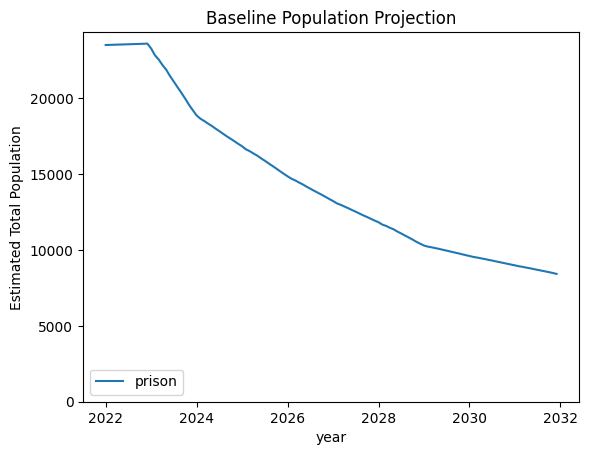

In [45]:
#This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments)

[<Axes: title={'center': 'compartment: pretrial\nadmission_to: prison'}, xlabel='time_step'>]

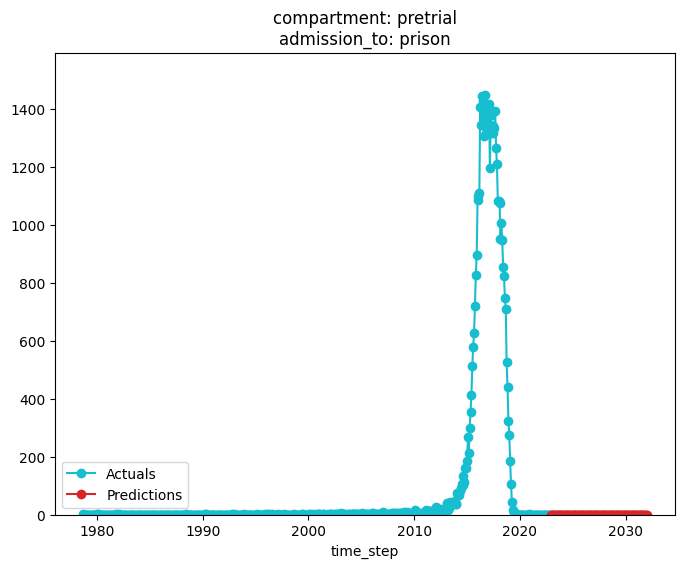

In [46]:
spark_sim.get_arima_output_plots('baseline_projections')

initialization time:  7.349050283432007
initialization time:  8.196149826049805
simulation_time:  13.2988760471344


simulation_time:  12.349860429763794
25945.425000000007


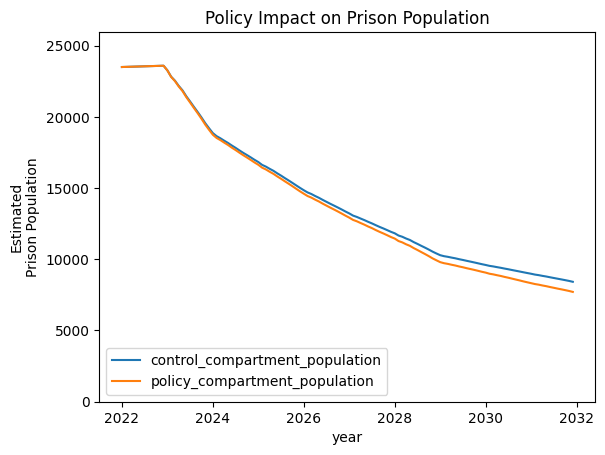

In [47]:
# [CHANGE THIS!!!]

def second_look(age_group):
    return SparkPolicy(
        spark_compartment='prison',
        simulation_group=age_group,
        alternate_transitions_data=alternate_transitions_data[alternate_transitions_data['simulation_group'] == age_group],
        apply_retroactive=True,
        policy_time_step=36 # Start in FY 2025 (36 timesteps after FY 2022)
    )

policy_list = []
for age_group in age_groups:
    policy_list.append(second_look(age_group))

test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [48]:
simulation_tag = 'second_look_' + scenario
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

NameError: name 'scenario' is not defined